<a href="https://colab.research.google.com/github/Pbonmars-20031006/Assignment-1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyqtree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import timeit
import random
from pyqtree import Index
from shapely.geometry import Point, Polygon

In [ ]:
# a class named rectdetails to store all the details of a given rectangle, helping in easy of access
class RectDetails:
    def __init__(self , rectangle_id, left_bottom_x, left_bottom_y, right_top_x, right_top_y):
        self.rectangle_id = rectangle_id  # stores the id of the rectangle
        self.left_bottom_corner_x = left_bottom_x  #stores the left bottom x coordinate
        self.left_bottom_corner_y = left_bottom_y  #stores the left bottom y coordinate
        self.right_top_corner_x = right_top_x #stores the right bottom x coordinate
        self.right_top_corner_y = right_top_y #stores the right bottom x coordinate


Saving test_data_new.txt to test_data_new (2).txt


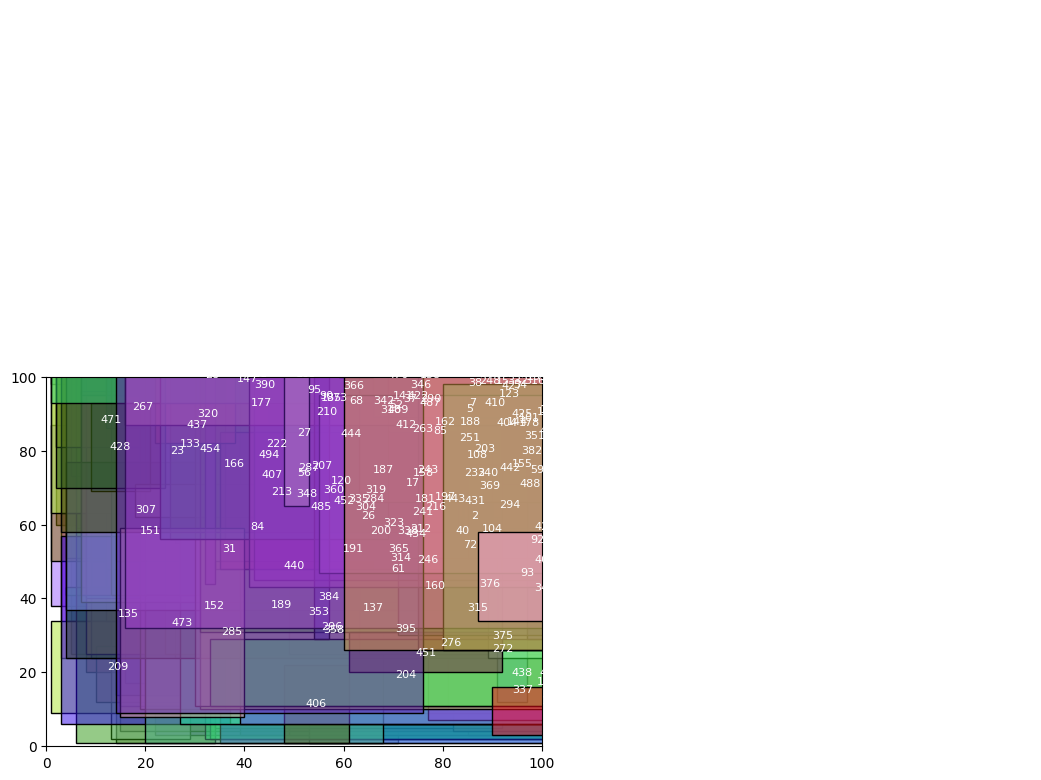

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io

def plot_rect(ax, position, size, rectangle_id):
    edge_color = 'black'
    face_color = (random.random(), random.random(), random.random(), 0.5)
    rectangle = patches.Rectangle(position, size[0], size[1], edgecolor=edge_color, facecolor=face_color,)
    ax.add_patch(rectangle)

    # Display rectangle ID as a label inside the rectangle
    ax.text(position[0] + size[0] / 2, position[1] + size[1] / 2, str(rectangle_id),
            color='white', ha='center', va='center', fontsize=8)

# def read_file_content(file_content):
#     rectangles = []

#     first_line = True
#     for line in file_content:
#         line = line.strip()

#         if line:
#             if first_line:
#                 numbers_str = line[2:-2].strip()
#                 first_line = False
#             else:
#                 numbers_str = line[1:-2].strip()

#             if numbers_str:
#                 individual_numbers = [num.strip() for num in numbers_str.split(',') if num.strip()]
#                 set_of_numbers = list(map(int, individual_numbers))
#                 rectangles.append(set_of_numbers)

#     return rectangles
def read_rectangles_from_file(file_content):
    rectangles = []
    for line in file_content:
        try:
            # Attempt to parse the line, ignoring invalid lines
            data = list(map(int, line.strip('{}\n, ').split(',')))
            rectangles.append(data)
        except ValueError:
            # Skip lines that cannot be converted to integers
            pass
    return rectangles


def is_point_inside_rect(point, rect_instance):
    x, y = point
    return (
        rect_instance.left_bottom_corner_x <= x <= rect_instance.right_top_corner_x and
        rect_instance.left_bottom_corner_y <= y <= rect_instance.right_top_corner_y
    )

def find_enclosing_rectangles(point, rectangles):
    enclosing_rectangles = []

    for index, set_of_numbers in enumerate(rectangles, start=1):
        rect_instance = RectDetails(*set_of_numbers)
        if is_point_inside_rect(point, rect_instance):
            enclosing_rectangles.append(index)

    return enclosing_rectangles

def find_enclosing_rectangles_quad(point, qtree):
    enclosing_rectangles = []
    x, y = point

    for rect_params in qtree.intersect((x, y, x, y)):
        enclosing_rectangles.append(rect_params.rectangle_id)

    return enclosing_rectangles

def find_non_overlapping_rectangles(rectangles, qtree):
    non_overlapping_rectangles = set()

    for rect_instance in rectangles:
        bbox = (rect_instance[1], rect_instance[2], rect_instance[3], rect_instance[4])

        if not any(qtree.intersect(bbox)):
            non_overlapping_rectangles.add(rect_instance[0])

    return non_overlapping_rectangles

def batch_insert(qtree, rectangles):
    for rect_params in rectangles:
        rect_instance = RectDetails(*rect_params)
        qtree.insert(item=rect_instance, bbox=(rect_instance.left_bottom_corner_x,
                                              rect_instance.left_bottom_corner_y,
                                              rect_instance.right_top_corner_x,
                                              rect_instance.right_top_corner_y))

def main():
    # Upload your_file.txt
    uploaded = files.upload()

    # Get the name of the uploaded file
    file_name = list(uploaded.keys())[0]

    # Create a file-like object from the uploaded content
    file_content = uploaded[file_name].decode('utf-8')
    rectangles = read_rectangles_from_file(io.StringIO(file_content))

    qtree = Index(bbox=(0, 0, 100, 100))
    batch_size = 1000  # Adjust the batch size based on your available memory

# Process the dataset in batches
    # for rect_params in rectangles:
    #     rect_instance = RectDetails(*rect_params)
    #     qtree.insert(item=rect_instance, bbox=(rect_instance.left_bottom_corner_x,
    #                                            rect_instance.left_bottom_corner_y,
    #                                            rect_instance.right_top_corner_x,
    #                                            rect_instance.right_top_corner_y))

    # Plot the rectangles
    fig, ax = plt.subplots()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    for index, set_of_numbers in enumerate(rectangles, start=1):
        rect_instance = RectDetails(*set_of_numbers)
        block_left_bottom = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y)
        size = [rect_instance.right_top_corner_x - rect_instance.left_bottom_corner_x,
                rect_instance.right_top_corner_y - rect_instance.left_bottom_corner_y]

        plot_rect(ax, block_left_bottom, size, index)

    plt.show()

    for i in range(0, len(rectangles), batch_size):
        batch = rectangles[i:i+batch_size]
        batch_insert(qtree, batch)


    x = float(input("Enter x coordinate: "))
    y = float(input("Enter y coordinate: "))
    point = (x, y)
    print("Naive")
    %timeit -r 1 -o find_enclosing_rectangles(point, rectangles)
    enclosing_rectangles_naive = find_enclosing_rectangles(point, rectangles)
    print("QuadTree")
    %timeit -r 1 -o find_enclosing_rectangles_quad(point, qtree)
    enclosing_rectangles_quadtree = find_enclosing_rectangles_quad(point, qtree)

    # Print the result for naive approach

    if enclosing_rectangles_naive:
        print(f"The point {point} is enclosed in the rectangles: {enclosing_rectangles_naive}")
    else:
        print(f"The point {point} is not enclosed in any rectangle.")

    # Print the result for quadtree approach

    if enclosing_rectangles_quadtree:
        print(f"The point {point} is enclosed in the rectangles: {enclosing_rectangles_quadtree}")
    else:
        print(f"The point {point} is not enclosed in any rectangle.")


    time_non_overlapping = timeit.timeit(lambda: find_non_overlapping_rectangles(rectangles, qtree), number=1)
    print(f"Time taken for finding non-overlapping rectangles: {time_non_overlapping} seconds")

    non_overlapping_rectangles_set = find_non_overlapping_rectangles(rectangles, qtree)
    print(f"Non-overlapping rectangles: {non_overlapping_rectangles_set}")


# Run the main function
if __name__ == "__main__":
    main()
